In [13]:
%matplotlib widget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import yfinance as yf
# import talib as ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.signal import savgol_filter
plt.style.use('light_background')

OSError: 'light_background' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [2]:
# Load data
start_date = '1800-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
symbol = "AAPL"
data = yf.download(symbol, start=start_date, end=end_date)

#Drops the ticker index row
data.columns = data.columns.droplevel(1)

#Removing index error
data.reset_index(inplace=True)
data.to_csv(f'{symbol}.csv', index=False)
data.to_csv('temp.csv', index=False)
data = pd.read_csv('temp.csv')
data.reset_index(inplace=True)
data.drop(columns = ['Close', 'High', 'Low', 'Open', 'Volume'], inplace = True)


[*********************100%***********************]  1 of 1 completed


In [43]:
data

,index,Date,Adj Close
0,0,1980-12-12,0.098834
1,1,1980-12-15,0.093678
2,2,1980-12-16,0.086802
3,3,1980-12-17,0.088951
4,4,1980-12-18,0.091530
...,...,...,...
11079,11079,2024-11-22,229.869995
11080,11080,2024-11-25,232.869995
11081,11081,2024-11-26,235.059998
11082,11082,2024-11-27,234.929993


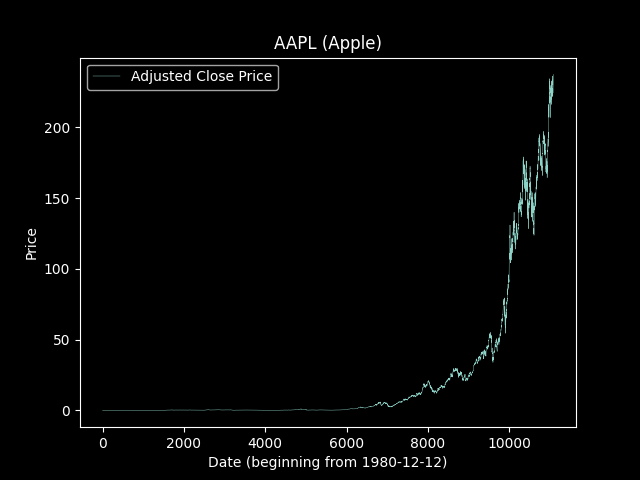

In [11]:
fig, ax = plt.subplots()
ax.plot(data['index'], data['Adj Close'], label='Adjusted Close Price', lw = 0.3)
ax.set_title(symbol + ' (Apple)')
ax.set_xlabel('Date (beginning from 1980-12-12)')
ax.set_ylabel('Price')
ax.legend()
plt.show()


In [ ]:
#Don't run, trial
data['Adj Close Smoothed'] = savgol_filter(data['Adj Close'], window_length=11, polyorder=2)

data['Adj Close difference'] = data['Adj Close'] - data['Adj Close Smoothed']
data['difference percentage'] = (data['Adj Close difference'] / data['Adj Close Smoothed']) * 100

fig, ax = plt.subplots()
ax.plot(data.index, data['Adj Close'], label='Adj Close')
ax.plot(data.index, data['Adj Close Smoothed'], label='Adj Close Smoothed')
ax.plot(data.index, data['difference percentage'], label='difference percentage')
ax.set_xlabel('Index')
ax.set_ylabel('Price')
ax.set_title('Stock Price')
ax.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to implement Savitzky-Golay filter from scratch
def savgol_filter_manual(y, window_length, poly_order):
    if window_length % 2 == 0:
        raise ValueError("window_length must be odd.")
    if window_length < poly_order + 1:
        raise ValueError("window_length must be greater than poly_order.")
    
    half_window = window_length // 2
    smoothed = np.zeros(len(y))

    # Iterate over each point in the signal
    for i in range(len(y)):
        # Define the window range
        start = max(0, i - half_window)
        end = min(len(y), i + half_window + 1)
        
        # Get the indices for the current window
        x_window = np.arange(start, end)
        y_window = y[start:end]

        # Fit a polynomial to the points in the window
        poly_coeffs = np.polyfit(x_window - x_window[len(x_window)//2], y_window, poly_order)

        # Evaluate the polynomial at the center point of the window
        poly = np.poly1d(poly_coeffs)
        smoothed[i] = poly(0)  # Evaluating at zero to represent the center
    
    return smoothed

# Generate sample noisy data
np.random.seed(42)
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x) + np.random.normal(0, 0.2, len(x))

# Apply the custom Savitzky-Golay filter
window_length = 11  # Must be odd
poly_order = 3
smoothed_y = savgol_filter_manual(y, window_length, poly_order)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Noisy Data', linestyle='dotted', color='blue')
plt.plot(x, smoothed_y, label='Smoothed Data', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Savitzky-Golay Filtering - Manual Implementation')
plt.show()


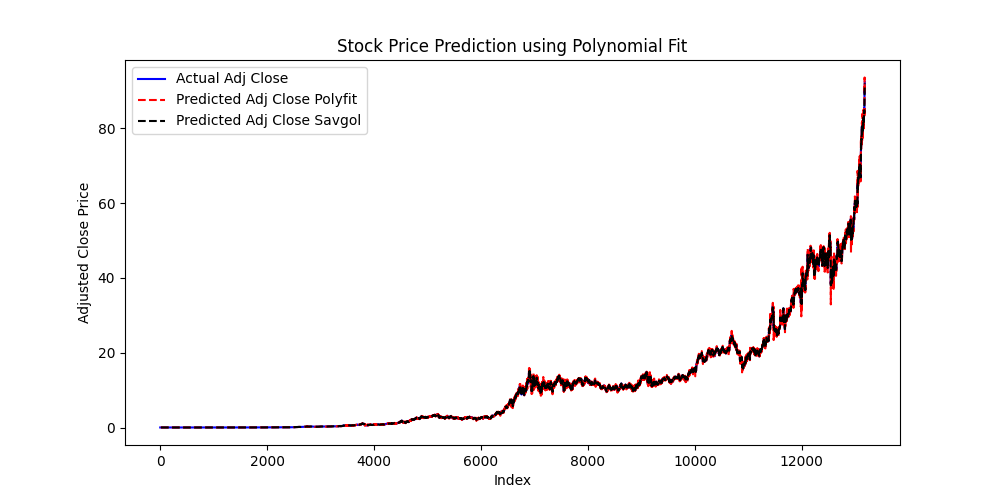

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for Savitzky-Golay-like fitting
window_length = 10  # Number of preceding points to use (must be less than len(data))
poly_order = 3  # Polynomial order to fit

# List to store the predicted values
predicted_values = []

# Loop through the data, starting from the point where we have enough preceding values
for i in range(window_length, len(data)):
    # Get the preceding 'window_length' values
    x = np.array(data['index'][i-window_length:i])
    y = np.array(data['Adj Close'][i-window_length:i])

    # Fit a polynomial of degree 'poly_order' to the preceding values
    coeffs = np.polyfit(x, y, poly_order)

    # Create a polynomial function from the coefficients
    poly = np.poly1d(coeffs)

    # Predict the next value (i.e., at x = data['index'][i])
    next_value = poly(data['index'][i])
    predicted_values.append(next_value)

# Add NaN values for the first 'window_length' rows since we can't predict for them
predicted_values = [np.nan] * window_length + predicted_values

# Add the predictions to the DataFrame
data['Predicted Adj Close Polyfit'] = predicted_values

# List to store the predicted values
predicted_values = []

# new_y = savgol_filter_manual(data['Adj Close'], 11, 3)

# Loop through the data, starting from the point where we have enough preceding values
for i in range(window_length, len(data)):
    # Get the preceding 'window_length' values
    x = np.array(data['index'][i-window_length:i])
    y = np.array(data['Adj Close'][i-window_length:i])

    # Generate weights: assign higher weight to more recent points
    weights = np.linspace(1, 2, window_length)  # Weights linearly increase from 1 to 2

    weights = np.exp(-0.5 * (np.linspace(-1, 0, window_length) ** 2))
    weights /= weights.sum()

    # Fit a polynomial of degree 'poly_order' to the preceding values with weights
    coeffs = np.polyfit(x, y, poly_order, w=weights)

    # Create a polynomial function from the coefficients
    poly = np.poly1d(coeffs)

    # Predict the next value (i.e., at x = data['index'][i])
    next_value = poly(data['index'][i])
    predicted_values.append(next_value)

# Add NaN values for the first 'window_length' rows since we can't predict for them
predicted_values = [np.nan] * window_length + predicted_values

# Add the predictions to the DataFrame
data['Predicted Adj Close Savgol'] = predicted_values
data['Predicted Adj Close Savgol'] = savgol_filter(data['Predicted Adj Close Savgol'], window_length=11, polyorder=2)

# Plot the original and predicted values
plt.figure(figsize=(10, 5))
plt.plot(data['index'], data['Adj Close'], label='Actual Adj Close', color='blue')
plt.plot(data['index'], data['Predicted Adj Close Polyfit'], label='Predicted Adj Close Polyfit', color='red', linestyle='dashed')
plt.plot(data['index'], data['Predicted Adj Close Savgol'], label='Predicted Adj Close Savgol', color='black', linestyle='dashed')
# plt.plot(data['index'], new_y, label='Predicted Adj Close Savgol', color='green', linestyle='dashed')
plt.xlabel('Index')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.title('Stock Price Prediction using Polynomial Fit')
plt.show()


In [ ]:
weights = np.linspace(1, 2, window_length)  # Weights linearly increase from 1 to 2
weights = np.exp(-0.5 * (np.linspace(-1, 0, window_length) ** 2))
weights /= weights.sum()

plt.figure(figsize=(10, 5))
plt.plot(weights)

In [36]:
data['Predicted Adj Close Savgol Shifted'] = data['Predicted Adj Close Savgol'].shift(-1)
data['Adj Close Shifted'] = data['Adj Close'].shift(-1)
data['Predicted Adj Close Polyfit Shifted'] = data['Predicted Adj Close Polyfit'].shift(-1)

data['Savgol prediction'] = (data['Predicted Adj Close Savgol Shifted'] - data['Adj Close']).apply(lambda x: -1 if x < 0 else 1)
data['reality'] = (data['Adj Close Shifted'] - data['Adj Close']).apply(lambda x: -1 if x < 0 else 1)
data['Polyfit prediction'] = (data['Predicted Adj Close Polyfit Shifted'] - data['Adj Close']).apply(lambda x: -1 if x < 0 else 1)

print('Savgol predictions:')
print((data['reality'] == data['Savgol prediction']).value_counts(), '\n\n')

print('Polyfit predictions:')
print((data['reality'] == data['Polyfit prediction']).value_counts())

Savgol predictions:
True     10071
False     3107
Name: count, dtype: int64 


Polyfit predictions:
True     6615
False    6563
Name: count, dtype: int64


In [ ]:
#Dont run, trial
plt.figure(figsize=(10, 5))
plt.plot(data['index'], data['Adj Close'], label='Actual Adj Close', color='blue')
plt.plot(data['index'], data['Predicted Adj Close Savgol'], label='Predicted Adj Close Savgol', color='black', linestyle='dashed')
plt.plot(data['index'], data['Predicted Adj Close Polyfit Shifted'], label='Predicted Adj Close Savgol Shifted', color='red', linestyle='dashed')
plt.plot(data['index'], data['Adj Close Shifted'], label='Actual Adj Close Shifted', color='green')
plt.xlabel('Index')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.title('Stock Price Prediction using Polynomial Fit')
plt.show()

In [37]:
#Getting only valid values?
start = window_length + 5
end = -1

close = list(data['Adj Close'])[start:end]
savgol_prediction = list(data['Savgol prediction'])[start:end]
close_shifted = list(data['Adj Close Shifted'])[start:end]
reality = list(data['reality'])[start:end]
polyfit_prediction = list(data['Polyfit prediction'])[start:end]

polyfit_predicted_sum = 0
savgol_predicted_sum = 0
sum = 0

for i in range(len(close)):
    if savgol_prediction[i] == -1:
        savgol_predicted_sum += close[i] - close_shifted[i]
    else:
        savgol_predicted_sum += close_shifted[i] - close[i]

for i in range(len(close)):
    if reality[i] == -1:
        sum += close[i] - close_shifted[i]
    else:
        sum += close_shifted[i] - close[i]

for i in range(len(close)):
    if polyfit_prediction[i] == -1:
        polyfit_predicted_sum += close[i] - close_shifted[i]
    else:
        polyfit_predicted_sum += close_shifted[i] - close[i]


print(f"Savgol predicted sum: {savgol_predicted_sum}")
print(f"Polyfit predicted sum: {polyfit_predicted_sum}")
print(f"Real sum: {sum}")


Savgol predicted sum: 1102.7105458420701
Polyfit predicted sum: -21.29854810610413
Real sum: 1465.128545917105


In [17]:
data.to_csv('data_appl.csv', index=False)

In [18]:
data

,index,Date,Adj Close,Predicted Adj Close Polyfit,Predicted Adj Close Savgol,Predicted Adj Close Savgol Shifted,Adj Close Shifted,Predicted Adj Close Polyfit Shifted,Savgol prediction,reality,Polyfit prediction
0,0,2010-06-29,1.592667,NaN,NaN,NaN,1.588667,NaN,1,-1,1
1,1,2010-06-30,1.588667,NaN,NaN,NaN,1.464000,NaN,1,-1,1
2,2,2010-07-01,1.464000,NaN,NaN,NaN,1.280000,NaN,1,-1,1
3,3,2010-07-02,1.280000,NaN,NaN,NaN,1.074000,NaN,1,-1,1
4,4,2010-07-06,1.074000,NaN,NaN,NaN,1.053333,NaN,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...
3626,3626,2024-11-22,352.559998,350.501040,357.062780,353.014004,338.589996,338.593323,1,-1,-1
3627,3627,2024-11-25,338.589996,338.593323,353.014004,343.744015,338.230011,322.142332,1,-1,-1
3628,3628,2024-11-26,338.230011,322.142332,343.744015,329.252811,332.890015,318.288004,-1,-1,-1
3629,3629,2024-11-27,332.890015,318.288004,329.252811,309.540392,345.160004,329.048016,-1,1,-1


In [38]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print('Savgol predictions:')
print(confusion_matrix(data['reality'], data['Savgol prediction']))

Savgol predictions:
[[4600 1345]
 [1762 5471]]


In [39]:
print('Classification report:')
print(classification_report(data['reality'], data['Savgol prediction']))

Classification report:
              precision    recall  f1-score   support

          -1       0.72      0.77      0.75      5945
           1       0.80      0.76      0.78      7233

    accuracy                           0.76     13178
   macro avg       0.76      0.77      0.76     13178
weighted avg       0.77      0.76      0.76     13178



In [40]:
accuracy = accuracy_score(data['reality'], data['Savgol prediction'])
precision = precision_score(data['reality'], data['Savgol prediction'], average='weighted', zero_division=0)
recall = recall_score(data['reality'], data['Savgol prediction'], average='weighted', zero_division=0)
f1 = f1_score(data['reality'], data['Savgol prediction'], average='weighted', zero_division=0)

In [41]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.764228259219912
Precision: 0.7667479518032436
Recall: 0.764228259219912
F1 Score: 0.7647235364326326


In [ ]:
data["Price Pct Change"] = data["Adj Close"].pct_change()
data["Price Pct Change"] = data["Price Pct Change"].shift(-1)
data["Price Pct Change"] = data["Price Pct Change"].fillna(0)

data["Dollar Volume"] = data["Adj Close"] * data["Volume"]
data["Dollar Volume Pct Change"] = data["Dollar Volume"].pct_change()
data["Dollar Volume Pct Change"] = data["Dollar Volume Pct Change"].shift(-1)

data.head()

In [ ]:
#moving average
data["MA5"] = data["Adj Close"].rolling(window=5).mean()
data["MA20"] = data["Adj Close"].rolling(window=20).mean()
data["MA50"] = data["Adj Close"].rolling(window=50).mean()
data["MA200"] = data["Adj Close"].rolling(window=200).mean()

#RSI
data["RSI"] = ta.RSI(data["Adj Close"], timeperiod=14)

#MACD
data["MACD"], data["Signal Line"], data["MACD Histogram"] = ta.MACD(data["Adj Close"], fastperiod=12, slowperiod=26, signalperiod=9)

#Bollinger Bands
data["Upper Band"], data["Middle Band"], data["Lower Band"] = ta.BBANDS(data["Adj Close"], timeperiod=20)

data = data.dropna()

data.head()



In [ ]:
# Use adjusted closing prices
closing_prices = data[['Adj Close']]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Prepare training and testing datasets
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

# Prepare data for LSTM
look_back = 60  # Number of past days to consider
X, y = create_dataset(scaled_data, look_back)

# Reshape X to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predict for the next 5 days
inputs = scaled_data[-look_back:]
inputs = inputs.reshape(1, look_back, 1)
predictions = []

for _ in range(5):
    pred = model.predict(inputs)[0][0]
    predictions.append(pred)
    
    # Reshape `pred` to have the same dimensions as `inputs` for concatenation
    pred_reshaped = np.array(pred).reshape(1, 1, 1)
    
    # Append the prediction to the end of inputs and shift the window
    inputs = np.append(inputs[:, 1:, :], pred_reshaped, axis=1)

# Convert predictions back to original scale
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Display the predictions
import matplotlib.pyplot as plt

plt.plot(closing_prices.index, closing_prices['Adj Close'], label='Historical Data')
future_dates = pd.date_range(start=closing_prices.index[-1] + pd.Timedelta(days=1), periods=5)
plt.plot(future_dates, predicted_prices, label='Predicted (LSTM)', color='red')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

print(predicted_prices)